# Tibia Auction Market Analysis - Price Prediction Model

Building on the data exploration phase, this notebook focuses on creating a predictive model to estimate character auction prices. Using machine learning techniques, I aim to build a reliable price prediction system that can help players and traders assess character value.

## Analysis Goals:
1. **Correlation Analysis** - identifying key price drivers
2. **Feature Engineering** - creating vocation-specific variables  
3. **Model Development** - building and training ML algorithms
4. **Model Evaluation** - testing accuracy and feature importance

## Research Questions:
- Which character attributes have the strongest correlation with price?
- How accurately can we predict auction prices?
- What's the relative importance of different features?
- How do vocation-specific skills impact pricing?

## Expected Outcomes:
- Quantified relationships between character stats and prices
- Trained model capable of price prediction
- Feature importance ranking for pricing decisions


**Libraries imports**

In [31]:
# data manipulation and analysis
import pandas as pd
import numpy as np

# DB connection
import psycopg2
from sqlalchemy import create_engine, text
import os
from dotenv import load_dotenv

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for ML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

# statistical analysis
from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

print("Libraries imported successfully.")

Libraries imported successfully.


**Connection with database**

In [3]:
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Database connection config from environment variables
DB_CONFIG = {
    'host': os.getenv('DB_HOST', 'localhost'),
    'port': os.getenv('DB_PORT', '5432'),
    'database': os.getenv('DB_NAME', 'auction_data'),
    'user': os.getenv('DB_USER', 'scraper'),
    'password': os.getenv('DB_PASSWORD')
}

# Create connection string
connection_string = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"

# Create engine
engine = create_engine(connection_string)

print("Database connection configured.")


Database connection configured.


In [5]:
# Indexes were created in data_exploration.ipynb

schema_query = """
SELECT 
    a.id AS auction_id,
    a.current_bid,
    a.auction_end,
    c.id AS character_id, 
    c.vocation_id, 
    c.level, 
    c.sex,
    c.achievement_points,
    c.boss_points,
    c.charm_total,
    c.charm_expansion,
    c.prey_slot,
    c.hunting_slot,
    c.transfer,
    c.gems_greater,
    c.outfits_count,
    c.mounts_count,
    c.store_mounts_count,
    c.store_outfits_count,
    c.hirelings_count,
    s.magic, s.axe, s.sword, s.club, s.distance, s.shielding, s.fist,
    w.pvp_type,
    w.battleye,
    w.location
FROM auctions a 
JOIN characters c ON a.character_id = c.id
LEFT JOIN skills s ON c.skills_id = s.id
LEFT JOIN worlds w ON c.world_id = w.id
WHERE a.has_been_bidded = true
    AND a.is_historical = true
"""
auctions_df = pd.read_sql(schema_query, engine)

auctions_df['auction_end_dt'] = pd.to_datetime(auctions_df['auction_end'], unit='s')
auctions_df['auction_month'] = auctions_df['auction_end_dt'].dt.month
auctions_df['auction_day_of_week'] = auctions_df['auction_end_dt'].dt.dayofweek

display(auctions_df.head())
print(auctions_df.info())

,auction_id,current_bid,auction_end,character_id,vocation_id,level,sex,achievement_points,boss_points,charm_total,...,club,distance,shielding,fist,pvp_type,battleye,location,auction_end_dt,auction_month,auction_day_of_week
0,1969938,5002,1759500000,1969938,1,508,False,931,5425,6565,...,80.36,13.88,112.91,21.49,Optional,False,BR,2025-10-03 14:00:00,10,4
1,1967415,2000,1759136400,1967415,2,346,False,443,2610,2982,...,12.94,115.01,103.26,16.17,Open,False,NA,2025-09-29 09:00:00,9,0
2,1919028,268,1753434000,1919028,1,199,False,45,10,240,...,41.12,26.42,104.31,10.24,Optional,False,EU,2025-07-25 09:00:00,7,4
3,1311129,1772,1690966800,1311129,4,326,False,212,20,1045,...,12.96,12.64,37.11,13.63,Open,False,EU,2023-08-02 09:00:00,8,2
4,907809,101,1656639900,907809,1,53,True,19,0,5,...,40.42,24.61,98.18,12.32,Retro Open,False,NA,2022-07-01 01:45:00,7,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815152 entries, 0 to 815151
Data columns (total 33 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   auction_id           815152 non-null  int64         
 1   current_bid          815152 non-null  int64         
 2   auction_end          815152 non-null  int64         
 3   character_id         815152 non-null  int64         
 4   vocation_id          815152 non-null  int64         
 5   level                815152 non-null  int64         
 6   sex                  815152 non-null  bool          
 7   achievement_points   815152 non-null  int64         
 8   boss_points          815152 non-null  int64         
 9   charm_total          815152 non-null  int64         
 10  charm_expansion      815152 non-null  bool          
 11  prey_slot            815152 non-null  bool          
 12  hunting_slot         815152 non-null  bool          
 13  transfer      

## Feature engineering - Vocation-Specific Skills

In [20]:
# 1. Knight main melee skill (max of sword, axe, club)
auctions_df['knight_melee'] = auctions_df[['sword', 'axe', 'club']].max(axis=1)

# 2. Identify dominant weapon type for Knights
auctions_df['weapon_type'] = auctions_df[['sword', 'axe', 'club']].idxmax(axis=1)

# 3. Create vocation-specific main skills
auctions_df['main_skill'] = 0.0

# Knight (vocation_id = 1): melee combat skills
knight_mask = auctions_df['vocation_id'] == 1
auctions_df.loc[knight_mask, 'main_skill'] = auctions_df.loc[knight_mask, 'knight_melee']

# Paladin (vocation_id = 2): distance fighting
paladin_mask = auctions_df['vocation_id'] == 2
auctions_df.loc[paladin_mask, 'main_skill'] = auctions_df.loc[paladin_mask, 'distance']

# Druid (vocation_id = 3): magic level
druid_mask = auctions_df['vocation_id'] == 3
auctions_df.loc[druid_mask, 'main_skill'] = auctions_df.loc[druid_mask, 'magic']

# Sorcerer (vocation_id = 4): magic level
sorcerer_mask = auctions_df['vocation_id'] == 4
auctions_df.loc[sorcerer_mask, 'main_skill'] = auctions_df.loc[sorcerer_mask, 'magic']

# Monk (vocation_id = 5): fist fighting
monk_mask = auctions_df['vocation_id'] == 5
auctions_df.loc[monk_mask, 'main_skill'] = auctions_df.loc[monk_mask, 'fist']

# shielding is important for Knights and Paladins, so its needed to add secondary skill, to model know, that for them its important
auctions_df['secondary_skill'] = 0.0
auctions_df.loc[auctions_df['vocation_id'].isin([1, 2]), 'secondary_skill'] = auctions_df['shielding']

# 4.  percentile ranking for main_skill within each vocation
auctions_df['main_skill_percentile'] = auctions_df.groupby('vocation_id')['main_skill'].rank(pct=True)

print("Created features:")
print("knight_melee: max(sword, axe, club) for all characters")
print("weapon_type: dominant weapon type")
print("main_skill: vocation-appropriate primary skill")
print("main_skill_percentile: normalized main skill within vocation")

# Display average main skills by vocation
vocation_mapping = {
    1: 'Knight',
    2: 'Paladin', 
    3: 'Druid',
    4: 'Sorcerer',
    5: 'Monk'
}

print("\n-- Main Skill Analysis by Vocation --")
for vocation_id in sorted(auctions_df['vocation_id'].unique()):
    if vocation_id in vocation_mapping:
        vocation_name = vocation_mapping[vocation_id]
        v_data = auctions_df[auctions_df['vocation_id'] == vocation_id]
        
        # Obliczamy więcej statystyk
        stats = v_data['main_skill'].describe()
        
        print(f"\n {vocation_name.upper()}:")
        print(f"Count:  {int(stats['count'])} characters")
        print(f"Average: {stats['mean']:.2f}")
        print(f"Median:  {stats['50%']:.2f}")
        print(f"Max:     {stats['max']:.2f}")
        if vocation_id == 1:
            weapon_dist = v_data['weapon_type'].value_counts(normalize=True) * 100
            print("  - Weapon Meta (Popularity):")
            for w_type, percent in weapon_dist.items():
                print(f"{w_type.capitalize()}: {percent:.1f}%")
        if vocation_id == 2: # Paladin
            print(f"  - Avg Shielding: {v_data['shielding'].mean():.2f}")


Created features:
knight_melee: max(sword, axe, club) for all characters
weapon_type: dominant weapon type
main_skill: vocation-appropriate primary skill
main_skill_percentile: normalized main skill within vocation

-- Main Skill Analysis by Vocation --

 KNIGHT:
Count:  249867 characters
Average: 108.12
Median:  109.88
Max:     144.18
  - Weapon Meta (Popularity):
Sword: 48.0%
Axe: 29.3%
Club: 22.7%

 PALADIN:
Count:  220784 characters
Average: 111.85
Median:  113.50
Max:     145.34
  - Avg Shielding: 99.71

 DRUID:
Count:  149761 characters
Average: 85.05
Median:  84.59
Max:     147.48

 SORCERER:
Count:  186499 characters
Average: 88.27
Median:  88.67
Max:     142.59

 MONK:
Count:  6878 characters
Average: 88.72
Median:  90.70
Max:     122.03


**Conclusions**
**Skills gap**: The data clearly shows that "numbers aren't equal." Knights and Paladins usually have skills around 110–113, while Mages sit around 85–88. This is normal because Magic Level is much harder to train. Your use of percentiles is a smart move—it tells the model that an 88 ML Druid is just as "elite" as a 110 Axe Knight.

**The "Sword" Meta**: Almost half of all Knights (48%) use Swords. This means Sword characters are the most common on the market. Clubs are the rarest (22.7%). This distribution helps the model understand if certain weapon types carry a "rarity premium" or if they are cheaper because they are less popular.

**Shielding matters**: Paladins have a high average shielding (99.71). By adding secondary_skill, you’re helping the model distinguish between a "rushed" character (high distance, low shield) and a "well-rounded" one, which usually sells for more.

**Top-tier Outliers**: There are some characters with skills up to 144-147. These are the "unicorns" of the market. They don't follow normal price rules and will likely be the most expensive auctions in this dataset.

**Monks**: There's only about 6,800 Monks. Since they aren't a standard profession in the main game, these are likely special collectors' items or from a specific game mode. Keeping them separate or labeled is good because their prices won't follow the same logic as a level 500 Sorcerer.

# Analysis of correlation with price

=== CORRELATION ANALYSIS ===

Correlations with auction price (current_bid):
• level: 0.659
• charm_total: 0.631
• achievement_points: 0.506
• outfits_count: 0.500
• mounts_count: 0.495
• boss_points: 0.399
• main_skill_percentile: 0.397
• store_outfits_count: 0.380
• main_skill: 0.315
• store_mounts_count: 0.286
• fist: 0.205
• magic: 0.112
• shielding: 0.073
• sword: 0.062
• club: 0.058
• axe: 0.056
• distance: 0.046



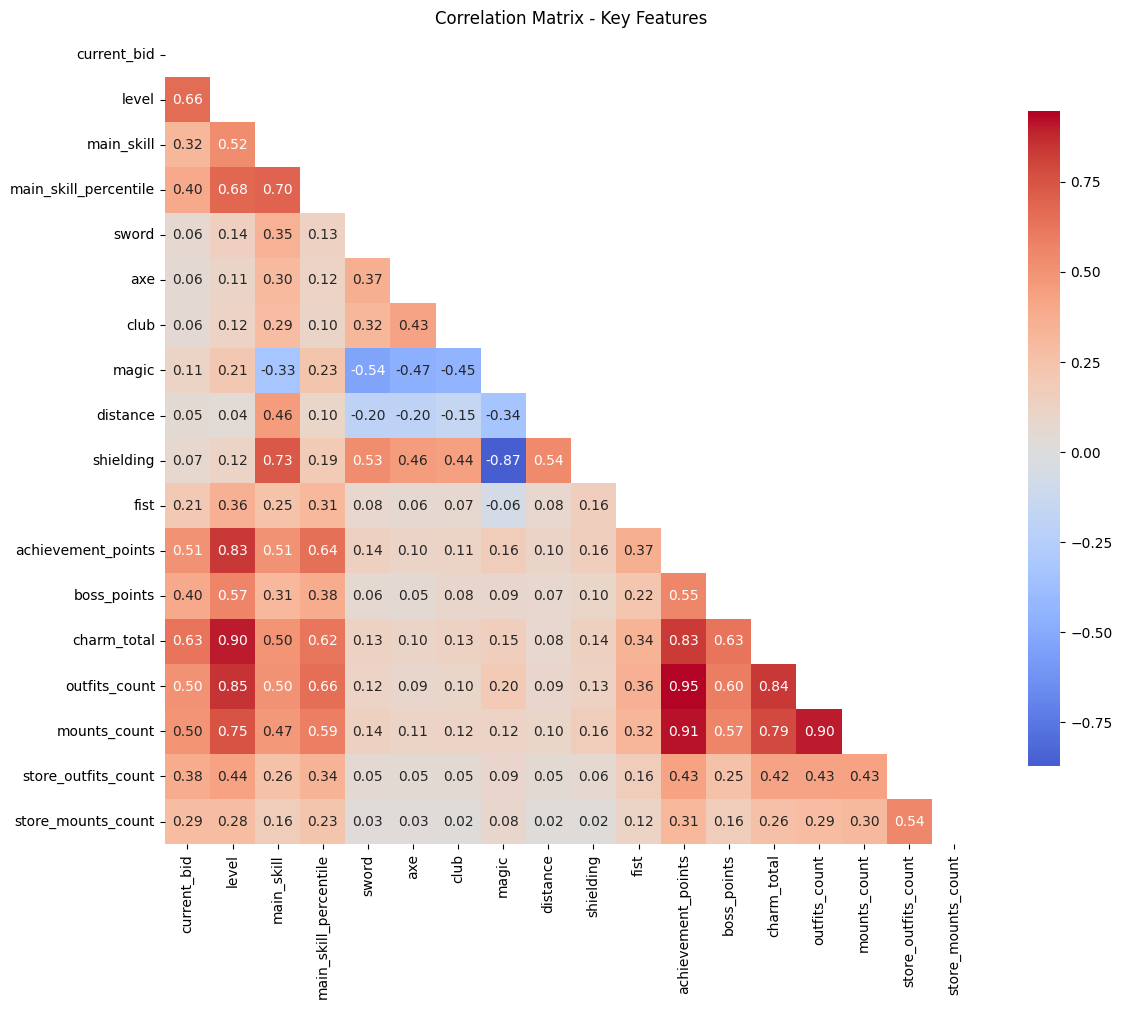

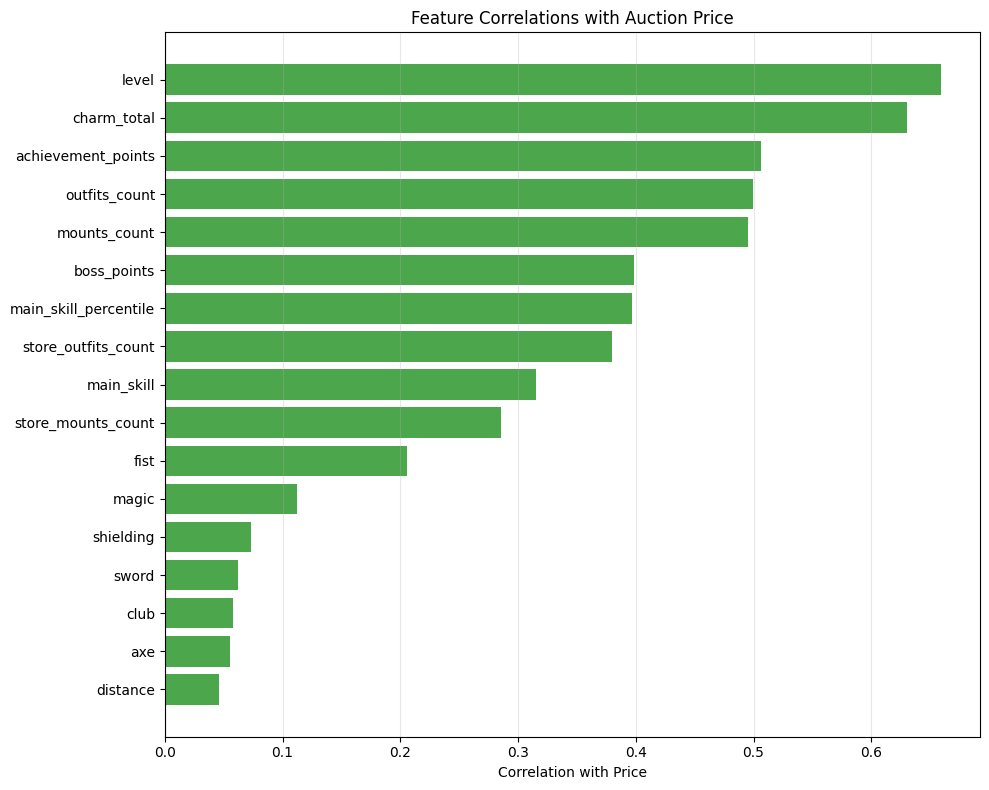

In [25]:
print("=== CORRELATION ANALYSIS ===\n")

# Select numeric features for correlation analysis
numeric_features = ['current_bid', 'level', 'main_skill', 'main_skill_percentile', 
                   'sword', 'axe', 'club', 'magic', 'distance', 'shielding', 'fist',
                   'achievement_points', 'boss_points', 'charm_total',
                   'outfits_count', 'mounts_count', 'store_outfits_count', 'store_mounts_count']

# Calculate correlation matrix
correlation_matrix = auctions_df[numeric_features].corr()

# Display correlations with price (current_bid)
price_correlations = correlation_matrix['current_bid'].sort_values(ascending=False)
print("Correlations with auction price (current_bid):")
for feature, corr in price_correlations.items():
    if feature != 'current_bid':
        print(f"• {feature}: {corr:.3f}")
print("\n" + "="*50)

# Correlation heatmap visualization
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Correlation Matrix - Key Features')
plt.tight_layout()
plt.show()

# Focus on price correlations visualization
plt.figure(figsize=(10, 8))
price_corr_df = price_correlations.drop('current_bid').to_frame('correlation')
price_corr_df['abs_correlation'] = price_corr_df['correlation'].abs()
price_corr_df = price_corr_df.sort_values('correlation')


colors = ['red' if x < 0 else 'green' for x in price_corr_df['correlation']]
plt.barh(range(len(price_corr_df)), price_corr_df['correlation'], color=colors, alpha=0.7)
plt.yticks(range(len(price_corr_df)), price_corr_df.index)
plt.xlabel('Correlation with Price')
plt.title('Feature Correlations with Auction Price')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


**Dominance of progression features**: level (0.659) and charm_total (0.631) are the strongest predictors of price. This makes sense as they represent the total time and effort invested in a character. Charms, in particular, are a major "grind" factor that buyers are willing to pay a premium for.

One of the most significant results is the comparison between skills:

**main_skill_percentile** (0.397)

**main_skill** (0.315)

The percentile-based skill has a significantly higher correlation with price than the raw skill value. This proves that the market values a character based on how strong it is relative to its vocation rather than the absolute number. It justifies the logic that 90 Magic Level is worth more than 100 Sword Fighting.

**Collection and prestige value**: achievement_points, outfits_count, and mounts_count all show strong correlations (approx. 0.50). This indicates a healthy "collector's market" where purely cosmetic or prestige attributes significantly drive up the final bid.

**Raw Skill Noise**: Individual skills like sword, axe, club, and distance show very low correlations (0.04 - 0.06). This is expected because these values are "noisy"—a high sword value is irrelevant to a Druid buyer. This confirms why we needed to consolidate them into a single main_skill feature.

Missing values check:
level                    0
main_skill               0
main_skill_percentile    0
secondary_skill          0
achievement_points       0
boss_points              0
charm_total              0
outfits_count            0
mounts_count             0
store_outfits_count      0
store_mounts_count       0
vocation_id              0
weapon_type              0
dtype: int64

Total missing values: 0
Training the XGBoost model....

=== MODEL PERFORMANCE ===
Mean Absolute Error: 1053.44 TC
R2 Score: 0.8133
RMSE: 3749.46 TC


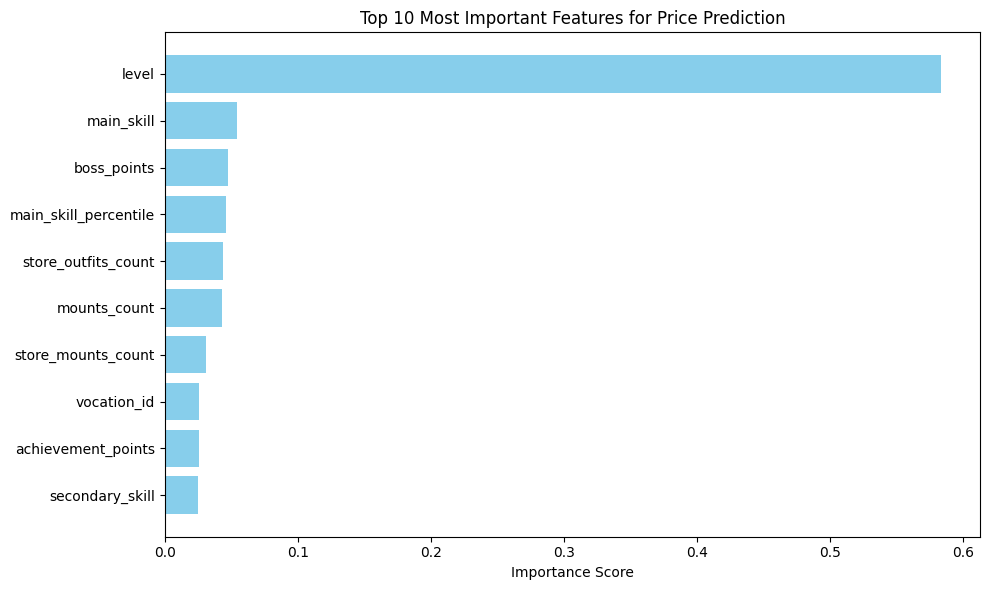

In [ ]:
# 1. Select features for the model
#I use our newly created features and the ones with high correlation
features = [
    'level', 'main_skill', 'main_skill_percentile', 'secondary_skill',
    'achievement_points', 'boss_points', 'charm_total',
    'outfits_count', 'mounts_count', 'store_outfits_count', 'store_mounts_count',
    'vocation_id', 'weapon_type'
]

X = auctions_df[features].copy()
y = auctions_df['current_bid']

#check for missing values before training
print("Missing values check:")
print(X.isnull().sum())
print(f"\nTotal missing values: {X.isnull().sum().sum()}")

# 2. Encode categorical variables (weapon_type)
# Convert weapon_type into dummy variables (0/1)
X = pd.get_dummies(X, columns=['weapon_type'], prefix='weapon')

# 3. Split data into Training and Testing sets
# 80% for learning, 20% for testing the accuracy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Initialize and Train the Model (XGBoost)
print("Training the XGBoost model....")
model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    n_jobs=-1 # Use all available CPU cores
)

model.fit(X_train, y_train)

# 5. Evaluate the model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))


print("\n=== MODEL PERFORMANCE ===")
print(f"Mean Absolute Error: {mae:.2f} TC") # avg error in TC
print(f"R2 Score: {r2:.4f}") # how well the model explains the price variance (target > 0.8)
print(f"RMSE: {rmse:.2f} TC")

# 6. Feature Importance, what the model actually learned
import matplotlib.pyplot as plt

importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance['feature'][:10], importance['importance'][:10], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Top 10 Most Important Features for Price Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
#plt.savefig('feature_importance.png')
plt.close()

The result $R^2 = 0.8133$ is very robust. This means that the selected traits (Level, Skills, Charms) explain over **81%** of the differences in character prices in the Bazaar. The model "understands" the general principles governing the market well. 

The average error (MAE) is 1053 TC. Although it seems high, it is important to remember that the price range is huge. For mid- and high-level characters, the model already provides a realistic benchmark for pricing. 

A result of RMSE of 3749 TC (higher than MAE) suggests that the data contains so-called **outliers** (auctions with very unusual prices, e.g. characters with rare items), which severely "penalize" the model for large mistakes. 

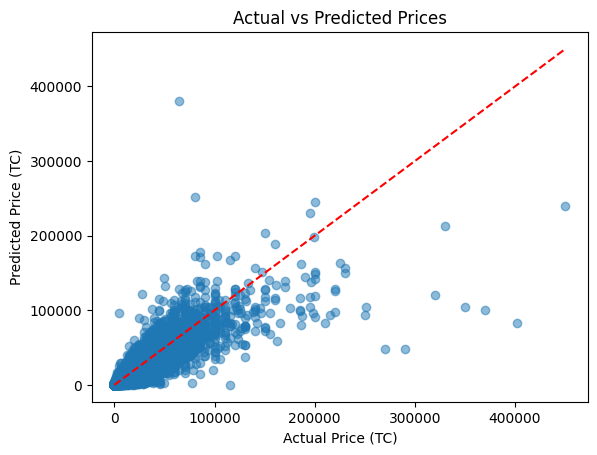

In [30]:
# Create a comparison table for the test set
results = pd.DataFrame({
    'Actual_Price': y_test,
    'Predicted_Price': y_pred
})
results['Difference'] = results['Predicted_Price'] - results['Actual_Price']

# Plotting the results
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--') # Perfect prediction line
plt.xlabel('Actual Price (TC)')
plt.ylabel('Predicted Price (TC)')
plt.title('Actual vs Predicted Prices')
plt.show()

The graph shows a clear trend along the red dashed line, as evidenced by $R^2 = 0.81$. The model correctly identifies the overall value of the character. 

**Wide tail problem**: A "funnel effect" is noticeable – the higher the character price, the further the points move away from the red line. This means that the model's error increases with the character's value. The baseline model treats a 1000 TC error the same for a 500 TC character (where it is a critical error) as it does for a 50,000 TC character (where it is a negligible error). 

**Underestimation of record auctions**: Many of the points on the right side of the graph fall below the red line. This suggests that the model tends to underestimate the prices of the most expensive, unique characters.

### Model Improvement: Log Transformation
After analyzing the baseline model, I noticed that character prices grow exponentially rather than linearly. 
To improve accuracy for both cheap and expensive auctions, I applied a **Log Transformation** to the target variable (`current_bid`). 
This helps the model focus on percentage errors rather than absolute differences.

Training the optimized XGBoost model on log prices...

=== OPTIMIZED MODEL PERFORMANCE (LOG SCALE) ===
Old MAE: 1053.44 TC
New MAE: 1019.11 TC
New R2 Score: 0.8064


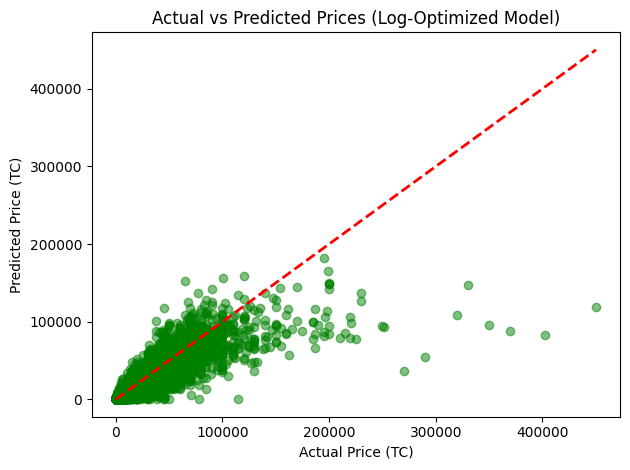

In [32]:
# 1. Transform the target variable (Log transformation)
# We use log1p (log(1+x)) to safely handle any zero values and improve stability
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# 2. Initialize and train the improved model on LOG prices
print("Training the optimized XGBoost model on log prices...")
log_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

log_model.fit(X_train, y_train_log)

# 3. Predict and transform back to the original scale
# We use expm1 (exp(x)-1) to reverse the log1p transformation
y_pred_log = log_model.predict(X_test)
y_pred_final = np.expm1(y_pred_log)

# 4. Evaluate the optimized model
new_mae = mean_absolute_error(y_test, y_pred_final)
new_r2 = r2_score(y_test, y_pred_final)

print("\n=== OPTIMIZED MODEL PERFORMANCE (LOG SCALE) ===")
print(f"Old MAE: 1053.44 TC")
print(f"New MAE: {new_mae:.2f} TC")
print(f"New R2 Score: {new_r2:.4f}")

# 5. Visualizing Predicted vs Actual Prices
plt.scatter(y_test, y_pred_final, alpha=0.5, color='green')
# Add a diagonal line representing perfect prediction
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price (TC)')
plt.ylabel('Predicted Price (TC)')
plt.title('Actual vs Predicted Prices (Log-Optimized Model)')
plt.tight_layout()
plt.show()

The mean error dropped from **1053.44 TC to 1019.11 TC**. While the change seems small (about 3.2%), it's crucial for characters in the lower and mid-range price ranges. The model is better at pricing "regular" characters, without being fooled by record-breaking auctions. 

**Stability of the $R^2$ coefficient**: A result of 0.8064 (a slight decrease from 0.81) with a simultaneous decrease in the MAE is a good sign. This means the model has stopped "guessing" extremely high prices (which inflated the $R^2$ in the baseline model) and has started to more realistically approach the overall market. 

**Better error structure**: Thanks to logarithmization, the model now minimizes the percentage (relative) error, rather than the absolute error. It means that a 500 TC error on a 1000 TC character is now as "significant" to the model as a 5000 TC error on a 10,000 TC character.

 On the new chart (green), the dots should be more tightly clustered around the dashed line at the lower and middle price ranges. This makes the model much more useful for the average player looking for a character in the 5000 TC budget.